In [ ]:
"""
Impute missing data based on mean value of k-nearest neighbors (KNNImputer)

"""

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

### 1. Load data

In [5]:
# Load csv file
df_train = pd.read_csv('../data_csv/aug_train.csv')
df_test = pd.read_csv('../data_csv/aug_test.csv')

In [6]:
test_target = np.load('../data_csv/jobchange_test_target_values.npy')

### 2. Examine missing values

In [7]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### 3. Cleaning and preparing data

Combine df_train and df_test for this part. (Given a new set of data, the missing values will be imputed based on the training data).

In [9]:
df = pd.concat([df_train,df_test],axis=0)
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15,NaN
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30,NaN
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18,NaN
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
mem

#### Preparation 1: convert string with order to float

In [11]:
# Replace string with float/int
df['experience'] = df['experience'].replace('>20','25')
df['experience'] = df['experience'].replace('<1','0.5')
df['experience'] = df['experience'].astype('float')
df['last_new_job'] = df['last_new_job'].replace('>4','5')
df['last_new_job'] = df['last_new_job'].replace('never','0')
df['last_new_job'] = df['last_new_job'].astype('float')

In [12]:
# Handle relevent_experience
relevent_experience_mapping={
    'Has relevent experience':1,
    'No relevent experience':0   
}
df.loc[:,'relevent_experience'] = df['relevent_experience'].map(relevent_experience_mapping)

In [13]:
# Handle enrolled_university
enrolled_university_mapping={
    'no_enrollment':0,
    'Part time course':1,
    'Full time course':2
}
df.loc[:,'enrolled_university'] = df['enrolled_university'].map(enrolled_university_mapping)

In [14]:
# Handle education_level
education_level_mapping={
    'Primary School':0,
    'High School':1,
    'Graduate':2,
    'Masters':3,
    'Phd':4
}
df.loc[:,'education_level'] = df['education_level'].map(education_level_mapping)

In [15]:
# Handle company_size
df['company_size'] = df['company_size'].replace('10/49','10-49')

company_size_mapping={
    '<10':0,
    '10-49':1,
    '50-99':2,
    '100-500':3,
    '500-999':4,
    '1000-4999':5,
    '5000-9999':6,
    '10000+':7    
}
df.loc[:,'company_size'] = df['company_size'].map(company_size_mapping)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  int64  
 5   enrolled_university     20870 non-null  float64
 6   education_level         20775 non-null  float64
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  float64
 9   company_size            14727 non-null  float64
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  float64
 12  training_hours          21287 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(7), int64(3), object(4)
memo

#### Preparation 2: convert string without order to numerical values (use pandas factorize)

In [17]:
# Create a dictionary to save the encoding and factorize the object type columns
char_cols = df.dtypes.pipe(lambda x: x[x == 'object']).index
label_mapping = {}

for c in char_cols:
    df[c], label_mapping[c] = pd.factorize(df[c])

In [18]:
label_mapping

{'city': Index(['city_103', 'city_40', 'city_21', 'city_115', 'city_162', 'city_176',
        'city_160', 'city_46', 'city_61', 'city_114',
        ...
        'city_107', 'city_18', 'city_139', 'city_180', 'city_166', 'city_121',
        'city_129', 'city_8', 'city_31', 'city_171'],
       dtype='object', length=123),
 'gender': Index(['Male', 'Female', 'Other'], dtype='object'),
 'major_discipline': Index(['STEM', 'Business Degree', 'Arts', 'Humanities', 'No Major', 'Other'], dtype='object'),
 'company_type': Index(['Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other',
        'Public Sector', 'NGO'],
       dtype='object')}

In [19]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0,0.920,0,1,0.0,2.0,0,25.0,NaN,-1,1.0,36,1.0
1,29725,1,0.776,0,0,0.0,2.0,0,15.0,2.0,0,5.0,47,0.0
2,11561,2,0.624,-1,0,2.0,2.0,0,5.0,NaN,-1,0.0,83,0.0
3,33241,3,0.789,-1,0,NaN,2.0,1,0.5,NaN,0,0.0,52,1.0
4,666,4,0.767,0,1,0.0,3.0,0,25.0,2.0,1,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,0,0.920,0,0,0.0,2.0,3,16.0,NaN,4,4.0,15,NaN
2125,195,36,0.897,0,1,0.0,3.0,0,18.0,NaN,-1,2.0,30,NaN
2126,31762,14,0.887,0,0,0.0,0.0,-1,3.0,NaN,0,0.0,18,NaN
2127,7873,12,0.804,0,1,2.0,1.0,-1,7.0,3.0,4,1.0,84,NaN


In [20]:
# Factorize converts NaN to -1
# Convert -1 back to NaN
df = df.replace(-1,np.nan)
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0,0.920,0.0,1,0.0,2.0,0.0,25.0,NaN,NaN,1.0,36,1.0
1,29725,1,0.776,0.0,0,0.0,2.0,0.0,15.0,2.0,0.0,5.0,47,0.0
2,11561,2,0.624,NaN,0,2.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,3,0.789,NaN,0,NaN,2.0,1.0,0.5,NaN,0.0,0.0,52,1.0
4,666,4,0.767,0.0,1,0.0,3.0,0.0,25.0,2.0,1.0,4.0,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,0,0.920,0.0,0,0.0,2.0,3.0,16.0,NaN,4.0,4.0,15,NaN
2125,195,36,0.897,0.0,1,0.0,3.0,0.0,18.0,NaN,NaN,2.0,30,NaN
2126,31762,14,0.887,0.0,0,0.0,0.0,NaN,3.0,NaN,0.0,0.0,18,NaN
2127,7873,12,0.804,0.0,1,2.0,1.0,NaN,7.0,3.0,4.0,1.0,84,NaN


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  int64  
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  float64
 4   relevent_experience     21287 non-null  int64  
 5   enrolled_university     20870 non-null  float64
 6   education_level         20775 non-null  float64
 7   major_discipline        18162 non-null  float64
 8   experience              21217 non-null  float64
 9   company_size            14727 non-null  float64
 10  company_type            14513 non-null  float64
 11  last_new_job            20824 non-null  float64
 12  training_hours          21287 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 

### 4. Impute missing values with kNNImputer

In [22]:
knn_imputer = KNNImputer(n_neighbors=3)
X = knn_imputer.fit_transform(df)

In [23]:
# pd.DataFrame(X, columns = df_train.columns)

In [24]:
df = pd.DataFrame(X, columns = df.columns).apply(lambda x: np.round(x))

In [25]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,25.0,4.0,0.0,1.0,36.0,1.0
1,29725.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,15.0,2.0,0.0,5.0,47.0,0.0
2,11561.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0,5.0,2.0,0.0,0.0,83.0,0.0
3,33241.0,3.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.0,1.0
4,666.0,4.0,1.0,0.0,1.0,0.0,3.0,0.0,25.0,2.0,1.0,4.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,1289.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,16.0,4.0,4.0,4.0,15.0,0.0
21283,195.0,36.0,1.0,0.0,1.0,0.0,3.0,0.0,18.0,4.0,0.0,2.0,30.0,0.0
21284,31762.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,18.0,0.0
21285,7873.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,7.0,3.0,4.0,1.0,84.0,0.0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  float64
 1   city                    21287 non-null  float64
 2   city_development_index  21287 non-null  float64
 3   gender                  21287 non-null  float64
 4   relevent_experience     21287 non-null  float64
 5   enrolled_university     21287 non-null  float64
 6   education_level         21287 non-null  float64
 7   major_discipline        21287 non-null  float64
 8   experience              21287 non-null  float64
 9   company_size            21287 non-null  float64
 10  company_type            21287 non-null  float64
 11  last_new_job            21287 non-null  float64
 12  training_hours          21287 non-null  float64
 13  target                  21287 non-null  float64
dtypes: float64(14)
memory usage: 2.3 MB


### 5. Separate df back to train and test set

In [27]:
df_train = df.iloc[:19158,:]
df_test = df.iloc[19158:,:].copy()

In [28]:
df_test['target'] = test_target

### 6. Pickle

In [29]:
df_train.to_pickle('../dump/df_train_knnImputed.csv')
df_test.to_pickle('../dump/df_test_knnImputed.csv')

In [30]:
df_test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
19158,32403.0,24.0,1.0,0.0,1.0,2.0,2.0,0.0,9.0,0.0,0.0,1.0,21.0,1.0
19159,9858.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,5.0,5.0,0.0,1.0,98.0,0.0
19160,31806.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,15.0,1.0
19161,27385.0,10.0,1.0,0.0,1.0,0.0,3.0,0.0,11.0,1.0,0.0,1.0,39.0,0.0
19162,27724.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,25.0,7.0,0.0,5.0,72.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,1289.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,16.0,4.0,4.0,4.0,15.0,0.0
21283,195.0,36.0,1.0,0.0,1.0,0.0,3.0,0.0,18.0,4.0,0.0,2.0,30.0,1.0
21284,31762.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,18.0,0.0
21285,7873.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,7.0,3.0,4.0,1.0,84.0,0.0


### 7. Quick test with Logistic Regression model

In [33]:
X_train = df_train.iloc[:,:-1]
y_train = df_train['target']
X_test = df_test.iloc[:,:-1]
y_test = df_test['target']

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization
lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py

,Predict-not changing (0),Predict-change (1)
Not changing (0),1541,12
Changing (1),552,24


In [35]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.7350868952559887 

Classification report (Logistic regression):

               precision    recall  f1-score   support

         0.0       0.74      0.99      0.85      1553
         1.0       0.67      0.04      0.08       576

    accuracy                           0.74      2129
   macro avg       0.70      0.52      0.46      2129
weighted avg       0.72      0.74      0.64      2129



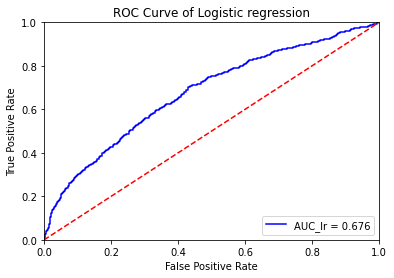

In [36]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.show()

### 8. Quick test with XGBoost model

In [31]:
X = df_train.iloc[:,:-1]
y = df_train['target']
X_test = df_test.iloc[:,:-1]
y_test = df_test['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2 ,random_state = 42)

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_train_pred = xgb.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = xgb.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_val = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Validation AUC Score {auc_val}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

In [ ]:
# Validation score is a lot lower than train score --> overfitting!

In [ ]:
pred = xgb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('Test AUC Score', roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

In [ ]:
xgb = XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.2,
        min_child_weight=2,
        colsample_bytree=.5)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='auc', #auc
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

In [ ]:
# AUC is okay but low recall.